In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from collections import Counter
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("ibm-research/argument_quality_ranking_30k", "argument_quality_ranking")
df = ds["train"].to_pandas()

[nltk_data] Downloading package punkt to /home/dslvalex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
print("Shape:", df.shape)
print(df.head())

Shape: (20974, 7)
                                            argument  \
0  "marriage" isn't keeping up with the times.  a...   
1  .a multi-party system would be too confusing a...   
2  `people reach their limit when it comes to the...   
3  100% agree, should they do that, it would be a...   
4  A ban on naturopathy creates a cohesive front ...   

                                           topic    set        WA    MACE-P  \
0                     We should abandon marriage  train  0.846165  0.297659   
1           We should adopt a multi-party system  train  0.891271  0.726133   
2  Assisted suicide should be a criminal offence  train  0.730395  0.225212   
3                  We should abolish safe spaces  train  0.236686  0.004104   
4                      We should ban naturopathy  train  0.753805  0.337724   

   stance_WA  stance_WA_conf  
0          1        1.000000  
1         -1        1.000000  
2         -1        1.000000  
3          1        0.805517  
4          1   

In [40]:
# Null value check
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 argument          0
topic             0
set               0
WA                0
MACE-P            0
stance_WA         0
stance_WA_conf    0
dtype: int64


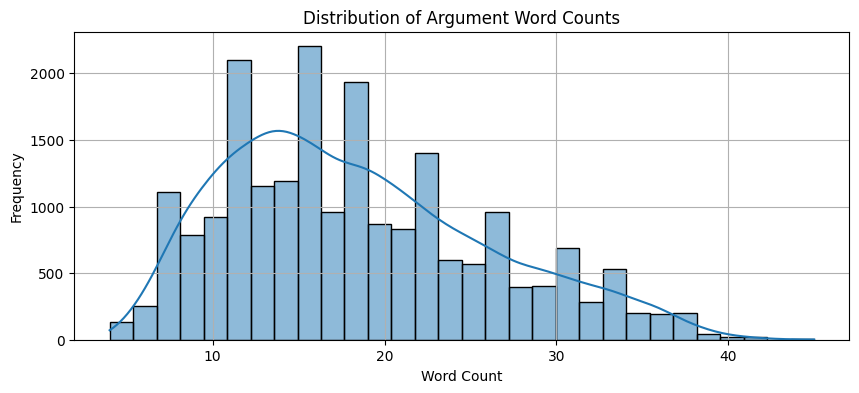


Minimum word count: 4
Maximum word count: 45


In [80]:
# character count
df["text_length"] = df["argument"].str.len()
# word count via regex (splits on word boundaries)
df["word_count"] = df["argument"].str.findall(r"\w+").str.len()


# Plot distribution of argument lengths
plt.figure(figsize=(10, 4))
sns.histplot(df["word_count"], bins=30, kde=True)
plt.title("Distribution of Argument Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

min_word_count = df["word_count"].min()
max_word_count = df["word_count"].max()
print(f"\nMinimum word count: {min_word_count}")
print(f"Maximum word count: {max_word_count}")

> **Note:** The Hugging Face page states:  
> *"We place a limit on argument length - a minimum of 35 characters and a maximum of 210 characters."*  
> However, in the dataset, the actual range of word counts is from **4** to **45**, not from 35 to 210.

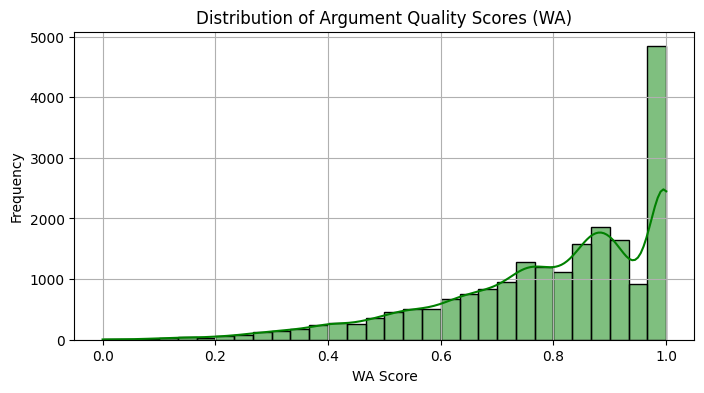

In [ ]:
# Quality score analysis
plt.figure(figsize=(8, 4))
sns.histplot(df["WA"], bins=30, kde=True, color='green')
plt.title("Distribution of Argument Quality Scores (WA)")
plt.xlabel("WA Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

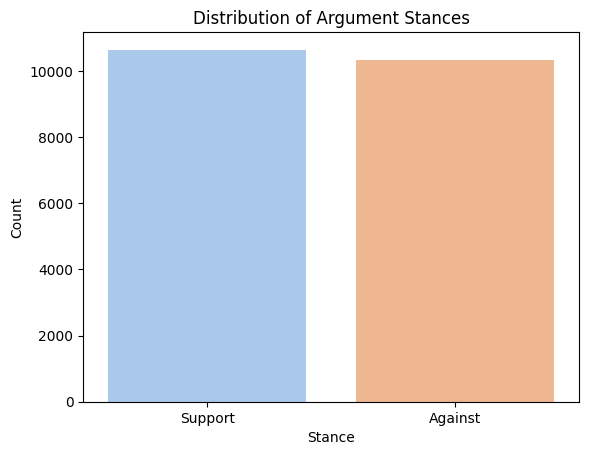

In [48]:
# Stance distribution
stance_map = {-1: "Against", 1: "Support"}
df["stance_label"] = df["stance_WA"].map(stance_map)


sns.countplot(data=df, x="stance_label", palette="pastel", hue="stance_label")
plt.title("Distribution of Argument Stances")
plt.xlabel("Stance")
plt.ylabel("Count")
plt.show()

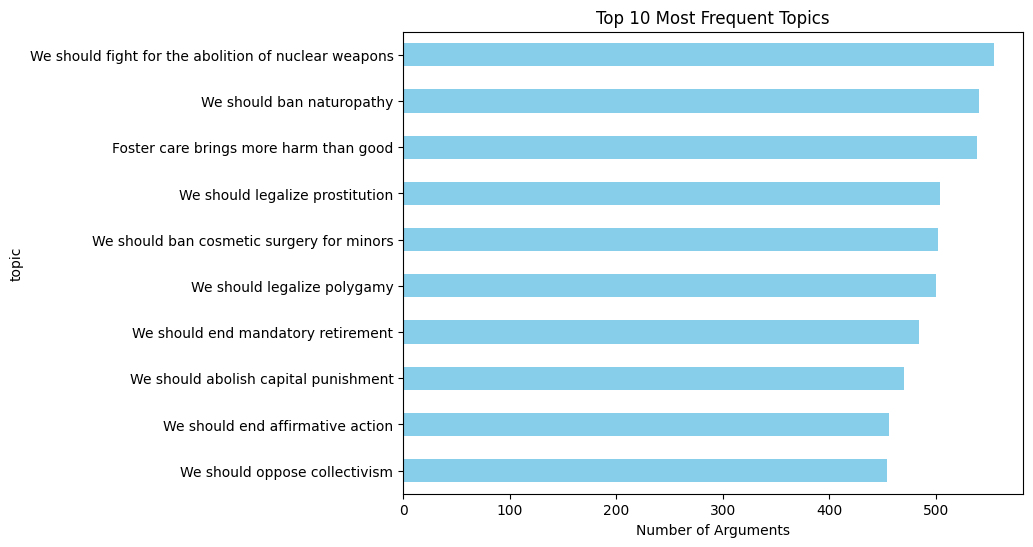

In [49]:
# Top debated topics
top_topics = df["topic"].value_counts().head(10)
top_topics.plot(kind="barh", figsize=(8, 6), color='skyblue')
plt.title("Top 10 Most Frequent Topics")
plt.xlabel("Number of Arguments")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Top 50 words by win rate

# Split into high‐quality vs low‐quality as before
threshold = df['WA'].median()
wins = df[df['WA'] > threshold]['argument']
loses = df[df['WA'] <= threshold]['argument']

# Build word counters
win_counter = Counter(re.findall(r"\w+", " ".join(wins).lower()))
lose_counter = Counter(re.findall(r"\w+", " ".join(loses).lower()))

# Compute win‐rate metric per word
data = []
for w in set(win_counter) | set(lose_counter):
    if w in ENGLISH_STOP_WORDS or w.isdigit():
        continue
    c_win = win_counter.get(w, 0)
    c_lose = lose_counter.get(w, 0)
    total = c_win + c_lose
    if total < 50:           # require min occurrences
        continue
    win_rate = c_win / total
    data.append((w, c_win, c_lose, total, win_rate))

# Sort by win_rate desc, tie‐breaker by win_count
data.sort(key=lambda x: (x[4], x[1]), reverse=True)
top50 = data[:50]

# Create DataFrame
top50_df = pd.DataFrame(top50, columns=[
    "Word", "Win_Count", "Lose_Count", "Total_Occurrences", "Win_Rate"
])

top50_df

,Word,Win_Count,Lose_Count,Total_Occurrences,Win_Rate
0,cures,53,6,59,0.898305
1,pollution,61,9,70,0.871429
2,rates,43,10,53,0.811321
3,endangered,58,15,73,0.794521
4,emotional,63,17,80,0.787500
5,discrimination,107,31,138,0.775362
6,expression,51,16,67,0.761194
7,obesity,79,25,104,0.759615
8,treatments,71,23,94,0.755319
9,knowledge,72,24,96,0.750000


In [68]:
# Top 50 words by lose‐rate

# 1. Split into high‐quality vs low‐quality
threshold = df['WA'].median()
wins  = df[df['WA'] >  threshold]['argument']
loses = df[df['WA'] <= threshold]['argument']

# 2. Build counters
win_counter  = Counter(re.findall(r"\w+", " ".join(wins).lower()))
lose_counter = Counter(re.findall(r"\w+", " ".join(loses).lower()))

# 3. Compute lose‐rate for each word
data = []
for w in set(win_counter) | set(lose_counter):
    if w in ENGLISH_STOP_WORDS or w.isdigit():
        continue
    c_win  = win_counter.get(w, 0)
    c_lose = lose_counter.get(w, 0)
    total  = c_win + c_lose
    if total < 50:           # filter low‐frequency
        continue
    lose_rate = c_lose / total
    data.append((w, c_win, c_lose, total, lose_rate))

# 4. Sort by lose_rate DESC, tiebreaker by lose_count
data.sort(key=lambda x: (x[4], x[2]), reverse=True)
top50_lose = data[:50]

# 5. Create DataFrame
top50_lose_df = pd.DataFrame(
    top50_lose,
    columns=["Word", "Win_Count", "Lose_Count", "Total_Occurrences", "Lose_Rate"]
)

top50_lose_df

,Word,Win_Count,Lose_Count,Total_Occurrences,Lose_Rate
0,think,43,169,212,0.797170
1,god,37,96,133,0.721805
2,everybody,14,36,50,0.720000
3,let,26,58,84,0.690476
4,kept,19,41,60,0.683333
5,religions,19,38,57,0.666667
6,shouldn,181,345,526,0.655894
7,say,26,48,74,0.648649
8,men,51,94,145,0.648276
9,waste,40,71,111,0.639640


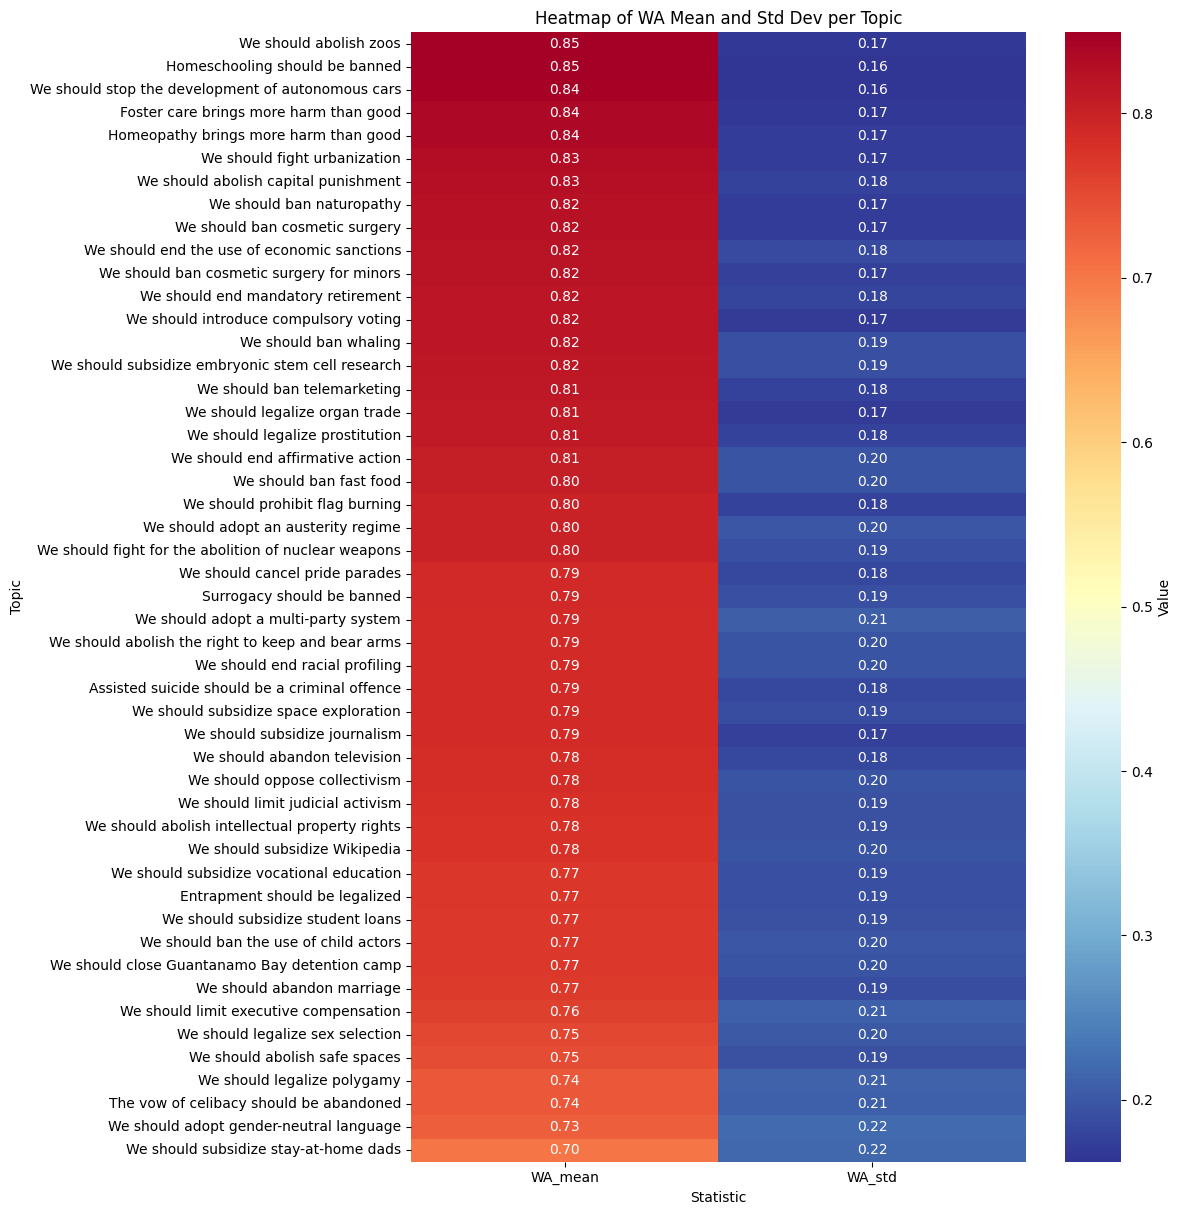

In [70]:
# Heatmap topic vs. qualité : calculer pour chaque sujet la moyenne et l’écart-type du score WA, 
# puis afficher une heatmap pour repérer les sujets où la qualité des arguments est globalement la plus forte ou la plus faible.

# 1. Make sure your DataFrame has a 'topic' column
if 'topic' not in df.columns:
    raise KeyError("Column 'topic' not found in df. Rename your column to 'topic' or adjust the code.")

# 2. Compute mean and std of WA per topic
topic_stats = (
    df
    .groupby('topic')['WA']
    .agg(WA_mean='mean', WA_std='std')
    .fillna(0)
    .sort_values('WA_mean', ascending=False)
)

# 3. Plot heatmap
plt.figure(figsize=(12, max(6, len(topic_stats) * 0.25)))
sns.heatmap(
    topic_stats,
    annot=True,
    fmt=".2f",
    cmap="RdYlBu_r",
    cbar_kws={'label': 'Value'}
)
plt.title("Heatmap of WA Mean and Std Dev per Topic")
plt.xlabel("Statistic")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

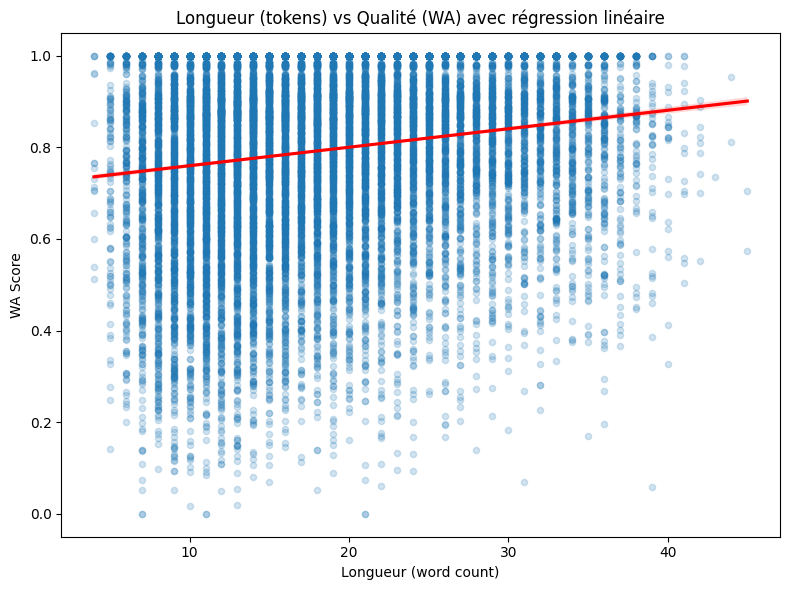

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter with linear regression
plt.figure(figsize=(8, 6))
sns.regplot(
    x="word_count",
    y="WA",
    data=df,
    scatter_kws={"alpha": 0.2, "s": 20},
    line_kws={"color": "red"},
    lowess=False
)
plt.title("Longueur (tokens) vs Qualité (WA) avec régression linéaire")
plt.xlabel("Longueur (word count)")
plt.ylabel("WA Score")
plt.tight_layout()
plt.show()

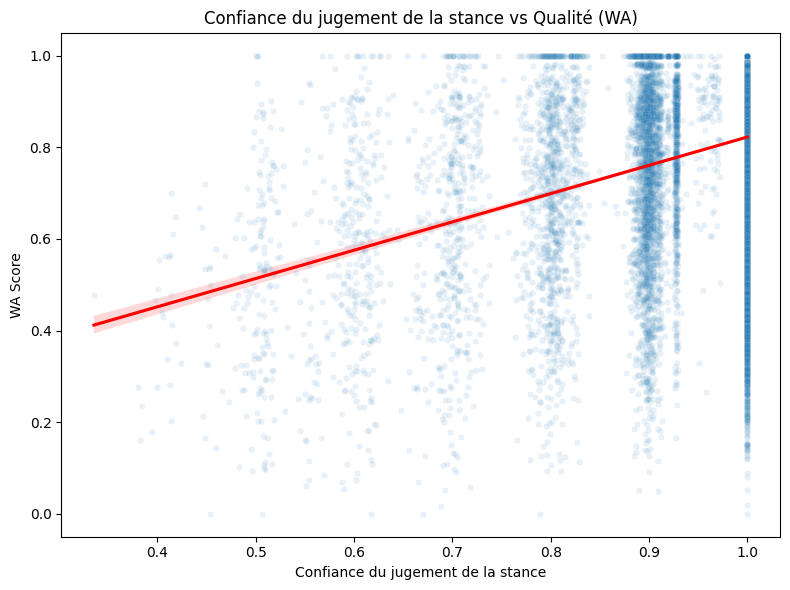

In [99]:
# Compare stance_WA_conf and WA
plt.figure(figsize=(8, 6))
reg = sns.regplot(
    x="stance_WA_conf",
    y="WA",
    data=df,
    scatter=False,
    line_kws={"color": "red"}
)
sns.scatterplot(
    x="stance_WA_conf",
    y="WA",
    data=df,
    ax=reg.axes,
    alpha=0.1,
    s=20
)
plt.title("Confiance du jugement de la stance vs Qualité (WA)")
plt.xlabel("Confiance du jugement de la stance")
plt.ylabel("WA Score")
plt.tight_layout()
plt.show()